<a href="https://colab.research.google.com/github/ras1364/DetectFakeReviewsUsing-Sentence_BERT/blob/main/FakeReviewDetectionUsingSentenceBertVer3_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this code, comments are sent to the Sentence BERT encoder regardless of the number of sentences, and its output is sent to the Dence network. We used the 'all-mpnet-base-v2' library and the result was 81% accuracy.**

In [ ]:
import pandas as pd
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from string import ascii_lowercase
from collections import Counter
import itertools, nltk, snowballstemmer, re

!pip install transformers
import transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 22.3 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving X_test.csv to X_test.csv
Saving X_train.csv to X_train.csv
Saving y_test.csv to y_test.csv
Saving y_train.csv to y_train.csv


In [ ]:
X_test = pd.read_csv("/content/X_test.csv")
X_train = pd.read_csv("/content/X_train.csv")
y_test = pd.read_csv("/content/y_test.csv")
y_train = pd.read_csv("/content/y_train.csv")

In [ ]:
max_length = 384
for x in range(0,len(X_train)):
  line = X_train.loc[x].at["text"]
  if max_length < len(line.split()) :
    max_length = len(line.split())

print(max_length)


649


In [ ]:
from gensim.parsing.preprocessing import remove_stopwords

def preprocess(text):
  return remove_stopwords(text)

X_train["stemmed_text_data"] = X_train["text"].map(preprocess)
X_test["stemmed_text_data"] = X_test["text"].map(preprocess)

In [ ]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('all-mpnet-base-v2')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.6 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=255332b484aae2dfd90ae8dd899f7e73e07cb50b77b5e03ec540aa95ade533b4
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


In [ ]:
X_train_encoded = sbert_model.encode(X_train["stemmed_text_data"] ,  show_progress_bar=True)
X_test_encoded = sbert_model.encode(X_test["stemmed_text_data"], show_progress_bar=True)

Batches:   0%|          | 0/38 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
print("X_train.shape = " , X_train_encoded.shape, " y_train.shape = ", y_train["deceptive"].shape)
print("X_test.shape = " , X_test_encoded.shape, " y_test.shape = ", y_test["deceptive"].shape)

X_train.shape =  (1200, 768)  y_train.shape =  (1200,)
X_test.shape =  (400, 768)  y_test.shape =  (400,)


In [ ]:
y_train

,Unnamed: 0,deceptive
0,620,0
1,923,1
2,916,1
3,608,0
4,938,1
...,...,...
1195,250,1
1196,401,0
1197,515,0
1198,1340,0


In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
# define and fit the final model
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
   ] 
model = Sequential()
model.add(Dense(64, input_shape=(768,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                49216     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 51,329
Trainable params: 51,329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_train_final = y_train.deceptive
model.fit(X_train_encoded,y_train_final, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
19/19 [==============================] - 1s 4ms/step - loss: 0.6838 - accuracy: 0.5675 - precision: 0.5436 - recall: 0.8417
Epoch 2/50
19/19 [==============================] - 0s 3ms/step - loss: 0.6365 - accuracy: 0.6983 - precision: 0.7156 - recall: 0.6583
Epoch 3/50
19/19 [==============================] - 0s 3ms/step - loss: 0.5700 - accuracy: 0.7300 - precision: 0.7331 - recall: 0.7233
Epoch 4/50
19/19 [==============================] - 0s 3ms/step - loss: 0.5090 - accuracy: 0.7650 - precision: 0.7819 - recall: 0.7350
Epoch 5/50
19/19 [==============================] - 0s 3ms/step - loss: 0.4688 - accuracy: 0.7958 - precision: 0.7915 - recall: 0.8033
Epoch 6/50
19/19 [==============================] - 0s 3ms/step - loss: 0.4370 - accuracy: 0.8050 - precision: 0.8339 - recall: 0.7617
Epoch 7/50
19/19 [==============================] - 0s 3ms/step - loss: 0.4135 - accuracy: 0.8192 - precision: 0.8389 - recall: 0.7900
Epoch 8/50
19/19 [==============================] - 0s 

In [ ]:
model.evaluate(X_test_encoded, y_test.deceptive)

13/13 [==============================] - 1s 8ms/step - loss: 0.6199 - accuracy: 0.8150 - precision: 0.8182 - recall: 0.8100


[0.6198536157608032,
 0.8149999976158142,
 0.8181818127632141,
 0.8100000023841858]

In [ ]:
y_predicted = model.predict(X_test_encoded)
y_predicted = y_predicted.flatten()

13/13 [==============================] - 0s 2ms/step


In [ ]:
import numpy as np
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test.deceptive, y_predicted)
cm 

array([[164,  36],
       [ 38, 162]])

Text(33.0, 0.5, 'Truth')

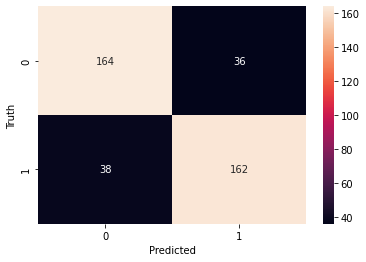

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test.deceptive, y_predicted))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       200
           1       0.87      0.78      0.82       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



In [ ]:
print(classification_report(y_test.deceptive, y_predicted))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82       200
           1       0.82      0.81      0.81       200

    accuracy                           0.81       400
   macro avg       0.82      0.81      0.81       400
weighted avg       0.82      0.81      0.81       400

